In [1]:
!git clone https://github.com/plana93/ARGO_Vision_CODEMOTION_2025.git
!pip install -e ARGO_Vision_CODEMOTION_2025
!pip install "git+https://github.com/plana93/sam2.git"
!pip install -q ipympl ipywidgets

fatal: destination path 'ARGO_Vision_CODEMOTION_2025' already exists and is not an empty directory.
Obtaining file:///content/ARGO_Vision_CODEMOTION_2025
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for CODEMOTION_2025 (pyproject.toml) ... done
  Created wheel for CODEMOTION_2025: filename=codemotion_2025-0.1.0-0.editable-py3-none-any.whl size=2903 sha256=5a2cf3f9e058f1d68da4c488277bfc5a4f9f5c7ae53e2393fea165dea4b54c97
  Stored in directory: /tmp/pip-ephem-wheel-cache-nse7o3fu/wheels/5b/cb/24/68e4d6865367b2eb40d237767b8b626120727f49411638f36e
Successfully built CODEMOTION_2025
  Attempting uninstall: CODEMOTION_2025
    Found existing installation: CODEMOTION_2025 0.1.0
    Uninstalling CODEMOTION_2025-0.1.0:
      Successfully uninstalled CODEMOTION_2025-0.1.0
  Cloning https://github.com/plana93/sam2.git

In [ ]:
import os

import sys
sys.path.append("../")
sys.path.append("./ARGO_Vision_CODEMOTION_2025")

import torch
from pathlib import Path
import numpy as np
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

from google.colab import output
output.enable_custom_widget_manager()

from codemotion2025.utils.download_image import download_image_from_url
from codemotion2025.utils.sam_utils import show_mask, show_points, show_frame, save_binary_mask, resize_all_to_largest, show_annotation_preview, save_image
from codemotion2025.utils.utils import print_shape

from sam2.sam2_video_predictor import SAM2VideoPredictor
from sam2.build_sam import build_sam2_video_predictor

print(matplotlib.get_backend())

module://matplotlib_inline.backend_inline


In [ ]:
class SAM2PredictorWrapper:
    def __init__(self, model_name="sam2-hiera-large"):
        self._predictor = SAM2VideoPredictor.from_pretrained(f"facebook/{model_name}")
        self._folder_dir = None
        self._frame_names = []
        self._inference_state = None

    def init_state(self, folder_dir: str, sort: bool = True):
        self._folder_dir = folder_dir
        self._frame_names = [p for p in os.listdir(folder_dir) if Path(p).suffix.lower() in {".jpg",".jpeg",".png",".bmp"}]
        if sort:
            self._frame_names.sort(key=lambda p: int(Path(p).stem.split("_")[1]))

        resize_all_to_largest(self._folder_dir, self._frame_names)
        self._inference_state = self._predictor.init_state(video_path=self._folder_dir)
        return self

    def reset_state(self):
        self._predictor.reset_state(self._inference_state)
        return self

    def get_img_name(self, idx: int) -> str :
        return self._frame_names[idx]

    def add_points(self, points, labels, obj_id=0, frame_idx=0, show=False):
        points = np.array(points); labels = np.array(labels)
        _, out_obj_ids, out_mask_logits = self._predictor.add_new_points_or_box(
            inference_state=self._inference_state,
            frame_idx=frame_idx,
            obj_id=obj_id,
            points=points,
            labels=labels
        )
        if show:
            show_frame(self._folder_dir, self._frame_names[frame_idx], frame_idx)
            show_points(points, labels, plt.gca())
            show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
        return self

    def add_points_batch(self, points_list, labels_list, obj_ids, frame_idxs, show=False):
        """Aggiunge più insiemi di punti a frame diversi."""
        for pts, lbls, obj_id, f_idx in zip(points_list, labels_list, obj_ids, frame_idxs):
            self.add_points(pts, lbls, obj_id=obj_id, frame_idx=f_idx, show=show)
        return self

    def propagate(self, show_every_n_frames: int = 0, plot=True, save_masks=False):
        video_segments = {}
        for out_frame_idx, out_obj_ids, out_mask_logits in self._predictor.propagate_in_video(self._inference_state):
            video_segments[out_frame_idx] = { out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
                                             for i, out_obj_id in enumerate(out_obj_ids) }

        if show_every_n_frames > 0 and plot:
            plt.close("all")
            for idx in range(0, len(self._frame_names), show_every_n_frames):
                if idx not in video_segments:
                    continue
                show_frame(self._folder_dir, self._frame_names[idx], idx)
                for obj_id, mask in video_segments[idx].items():
                    show_mask(mask, plt.gca(), obj_id=obj_id)

        if save_masks:
            masks_dir = Path(self._folder_dir) / "masks"
            fg_dir = Path(self._folder_dir) / "foreground"
            bg_dir = Path(self._folder_dir) / "background"
            for d in [masks_dir, fg_dir, bg_dir]:
                d.mkdir(parents=True, exist_ok=True)

            for idx in range(0, len(self._frame_names), show_every_n_frames):
                try:
                    frame_path = Path(self._folder_dir) / self._frame_names[idx]
                    img = np.array(Image.open(frame_path).convert("RGB"))

                    for obj_id, mask in video_segments[idx].items():
                        mask = np.squeeze(mask)
                        if mask.ndim > 2:
                            mask = mask[..., 0]

                        mask_bin = (mask > 0.5).astype(np.uint8)
                        mask_3 = np.stack([mask_bin]*3, axis=-1)

                        # Foreground & background
                        fg = img * mask_3
                        bg = img * (1 - mask_3)

                        # Build filenames
                        prefix = f"{str(obj_id)}_{self._frame_names[idx]}"

                        save_image(mask_bin * 255, masks_dir / f"mask_{prefix}.png")
                        save_image(fg, fg_dir / f"fg_{prefix}.png")
                        save_image(bg, bg_dir / f"bg_{prefix}.png")

                except KeyError:
                    continue

        return self

In [4]:
test_image = download_image_from_url()
if test_image and os.path.exists(test_image):
    print(f"Using image file at: {test_image}")
else:
    print("No valid image file is available.")

Enter the URL of an online image (or leave blank to use Colab upload): https://imgresizer.tntsports.io/unsafe/1200x0/filters:format(jpeg)/origin-imgresizer.tntsports.io/2016/03/13/1814260-38282471-2560-1440.jpg
Downloaded and saved image as: downloads/img_0006.jpg
Using image file at: downloads/img_0006.jpg


In [5]:
## CONFIGURATION
path_dataset = Path(test_image).parent
idx_img = 0
frame_offset = 1
num_repetition_first_frame = 1


In [76]:
m = SAM2PredictorWrapper().init_state(str(path_dataset), sort=False)
image_name = m.get_img_name(idx=idx_img)
image_complete_path = Path(path_dataset) / image_name
img = Image.open(image_complete_path).convert("RGB")

False True


frame loading (JPEG): 100%|██████████| 3/3 [00:00<00:00, 16.72it/s]


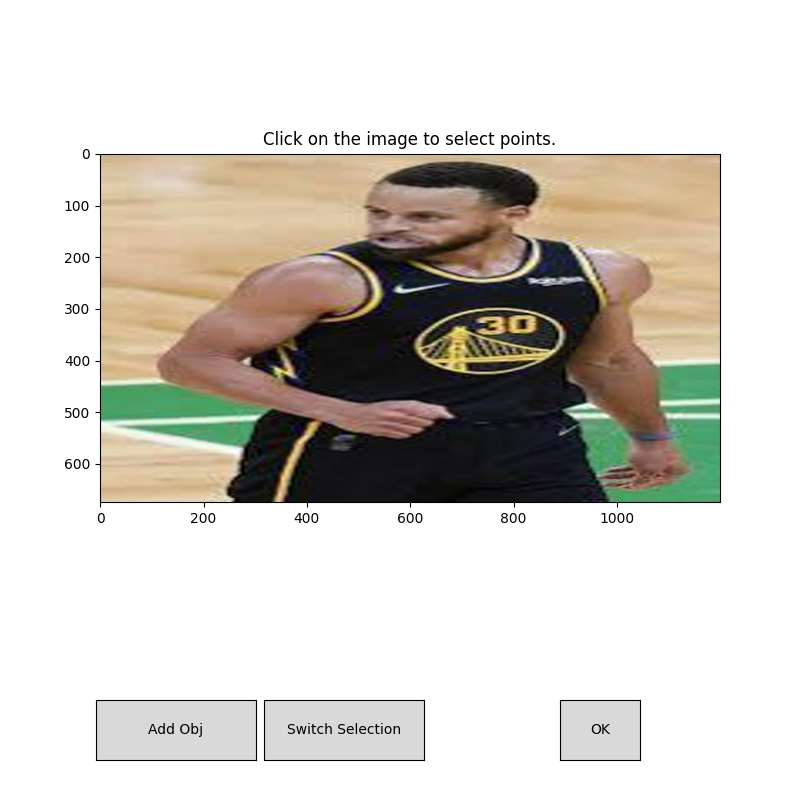

Oggetto 1 salvato con 5 punti.
Oggetto 2 salvato con 8 punti.

--- RESULTS ---
Obj 1 -> [[510, 383], [758, 398], [884, 263], [553, 247], [781, 619]]
Obj 2 -> [[359, 296], [253, 344], [601, 81], [758, 66], [764, 184], [1017, 232], [1005, 441], [500, 503]]

 Frame Annotated
Obj 1 -> [[510, 383], [758, 398], [884, 263], [553, 247], [781, 619]]
Obj 2 -> [[359, 296], [253, 344], [601, 81], [758, 66], [764, 184], [1017, 232], [1005, 441], [500, 503]]


In [ ]:
# @title

%matplotlib widget

points = []
obj_ids = []
labels = []
l_obj_ids = []

current_points = []

select_positive = True

def onclick(event):
    if event.inaxes == ax_img:  # click dentro l'immagine
        x, y = int(event.xdata), int(event.ydata)
        current_points.append([x, y])
        cmap = plt.get_cmap("tab10")  # choose a colormap
        color = cmap(len(obj_ids))
        ax_img.scatter(x, y, color=color)
        fig.canvas.draw()

def on_toggle(event):
    global select_positive
    select_positive = not select_positive
    mode = "Positive" if select_positive else "Negative"
    print(f"Switched to {mode} point selection.")

def add_obj(event):
    global current_points
    if current_points:
        points.append(current_points.copy())
        obj_ids.append(len(obj_ids) + 1)
        print(f"Oggetto {obj_ids[-1]} salvato con {len(current_points)} punti.")
        current_points = []  # reset buffer for new obj
    else:
        print("Nessun punto selezionato per questo oggetto!")

def on_ok(event):
    """Conferma selezione e stampa risultato finale."""
    if current_points:
        add_obj(None)

    if not points:
        print("Nessun oggetto creato! Seleziona punti e premi Add Obj.")
        return

    print("\n--- RESULTS ---")
    for i, obj in enumerate(points):
        print(f"Obj {obj_ids[i]} -> {obj}")

    fig.canvas.mpl_disconnect(cid_click)
    plt.close(fig)
    print("\n Frame Annotated")
    for i, obj in enumerate(points):
        print(f"Obj {obj_ids[i]} -> {obj}")
        l_obj_ids.append(obj_ids[i])
        labels.append([1]*len(obj))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.subplots_adjust(bottom=0.3)

ax_img = ax
ax_img.imshow(img)
ax_img.set_title("Click on the image to select points.")

ax_ok = plt.axes([0.7, 0.05, 0.1, 0.075])
ax_toggle = plt.axes([0.33, 0.05, 0.2, 0.075])
ax_add_obj = plt.axes([0.12, 0.05, 0.2, 0.075])

btn_ok = Button(ax_ok, 'OK')
btn_toggle = Button(ax_toggle, 'Switch Selection') # negative not used for now
btn_add_obj = Button(ax_add_obj, 'Add Obj')

# Eventi
cid_click = fig.canvas.mpl_connect('button_press_event', onclick)
btn_ok.on_clicked(on_ok)
btn_toggle.on_clicked(on_toggle) # negative not used for now
btn_add_obj.on_clicked(add_obj)

plt.show()






In [ ]:
frame_idxs = [idx_img] * len(l_obj_ids)
print_shape(points=points, labels=labels, obj_ids=obj_ids, frame_idxs=frame_idxs)


🔍 === DEBUG: Input Data Overview ===

• points      : type=list       | shape=ragged [2] (sub-shapes: [(5, 2), (8, 2)])
  content     : [[[510, 383], [758, 398], [884, 263], [553, 247], [781, 619]], [[359, 296], [253, 344], [601, 81], [...

• labels      : type=list       | shape=ragged [2] (sub-shapes: [(5,), (8,)])
  content     : [[1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2, 2]]

• obj_ids     : type=list       | shape=ragged [2] (sub-shapes: [(), ()])
  content     : [1, 2]

• frame_idxs  : type=list       | shape=ragged [2] (sub-shapes: [(), ()])
  content     : [0, 0]



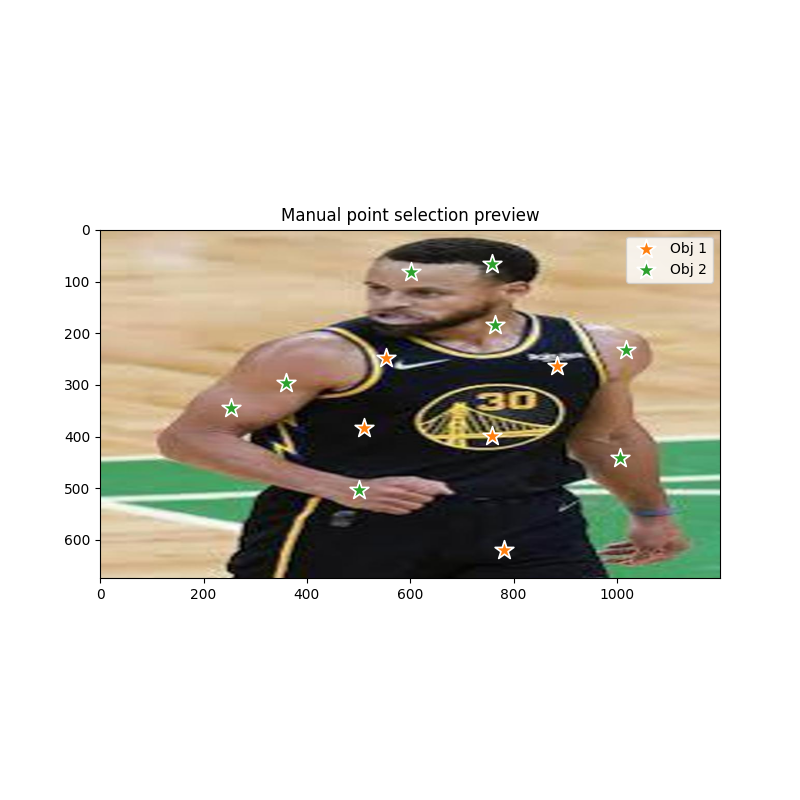

--- Annotation summary ---
Obj 1 -> [[510, 383], [758, 398], [884, 263], [553, 247], [781, 619]]
Obj 2 -> [[359, 296], [253, 344], [601, 81], [758, 66], [764, 184], [1017, 232], [1005, 441], [500, 503]]


In [ ]:
# @title Manual annotation (no interaction)


# --- Define manual points, labels, etc. ---

points = [
    [[510, 383], [758, 398], [884, 263], [553, 247], [781, 619]], # obj 1
    [[359, 296], [253, 344], [601, 81], [758, 66], [764, 184], [1017, 232], [1005, 441], [500, 503]] # obj 2
]

labels = [
    [1, 1, 1, 1, 1],
    [2, 2, 2, 2, 2, 2, 2, 2]
]

l_obj_ids = [1, 2]
frame_idxs = [idx_img] * len(l_obj_ids)




# --- Example usage ---
show_annotation_preview(img, points, l_obj_ids, labels)


/usr/local/lib/python3.12/dist-packages/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/usr/local/lib/python3.12/dist-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 3/3 [01:26<00:00, 28.80s/it]


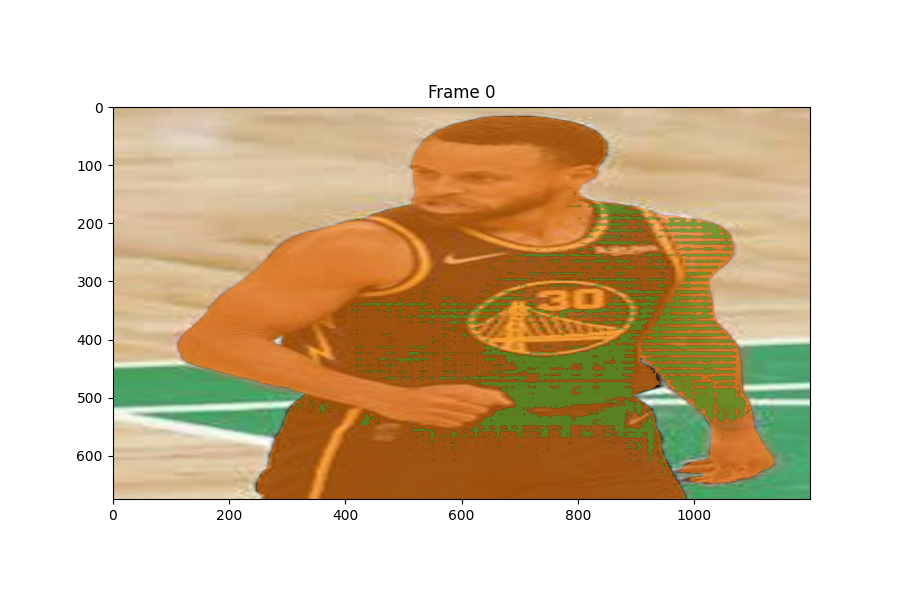

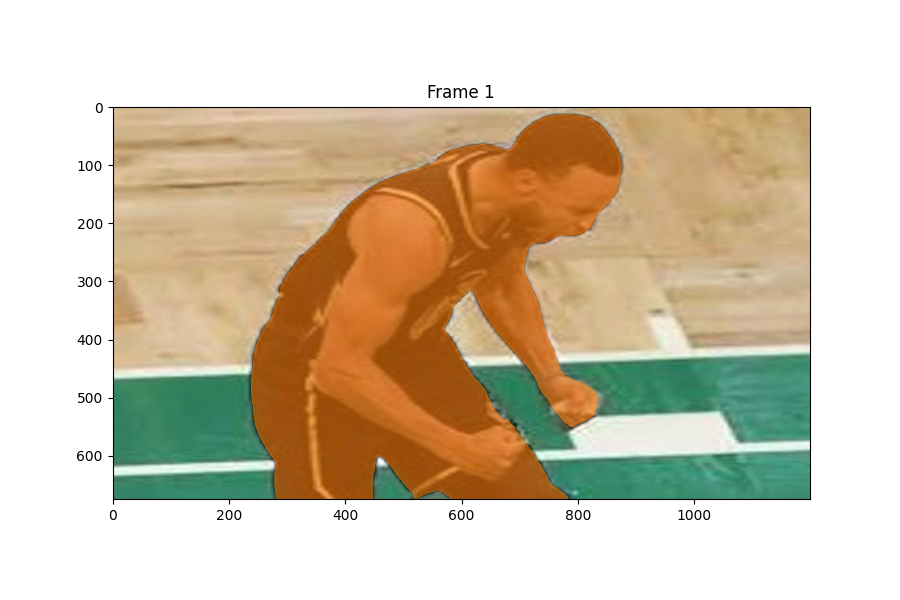

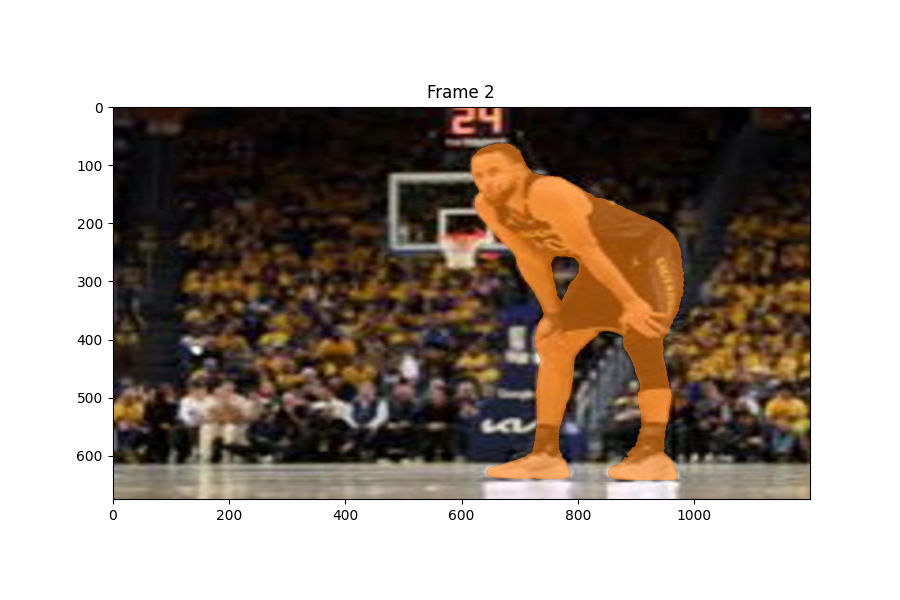

In [80]:
# reset the predictor state
m = m.reset_state()

# add initial user points multiple times on the first frame
for _ in range(num_repetition_first_frame):
    m = m.add_points_batch(
        points_list=points,
        labels_list=labels,
        obj_ids=l_obj_ids,
        frame_idxs=[idx_img] * len(l_obj_ids),
        show=False,
    )

# propagate segmentation across the images
m = m.propagate(show_every_n_frames=frame_offset, plot=True, save_masks=True)